In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from skimage.color import label2rgb
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.lines import Line2D
import geopandas as gpd
import networkx as nx
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.warp import transform
import scipy.ndimage as nd
from shapely.geometry import Point

from orinoco import (reproject_arr_to_match_profile, 
                     reproject_profile_to_new_crs, 
                     get_graph_from_edge_dataframe, 
                     get_cropped_profile)
from orinoco.plot import get_extent, make_map, rand_cmap

from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', family='serif', size=20)
plt.rcParams["text.usetex"] =True

# Load Data

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir_4326 = Path(f'{products_for_map_dir}_4326')


In [3]:
plot_dir = Path('plots')
plots_for_maps_dir = plot_dir/f'{map_name}'
plots_for_maps_dir.mkdir(exist_ok=True, parents=True)

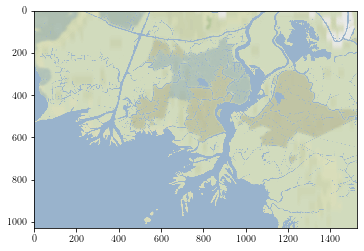

In [4]:
with rasterio.open(products_for_map_dir_4326/f'{map_name}.tif') as ds:
    arr = ds.read().transpose([1, 2, 0])[..., :3]
    profile = ds.profile
plt.imshow(arr)

In [5]:
with rasterio.open(products_for_map_dir_4326/'segments.tif') as ds:
    segments = label2rgb(ds.read(1), 
                         bg_label=0, 
                        )
    

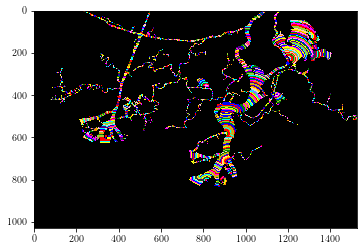

In [6]:
plt.imshow(segments)

In [7]:
with rasterio.open(products_for_map_dir_4326/'distance.tif') as ds:
    distance = ds.read(1)

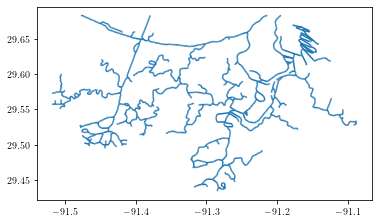

In [8]:
edges_df = gpd.read_file(products_for_map_dir/'orinoco_edges.geojson').to_crs({'init':'epsg:4326'})
edges_df.plot()

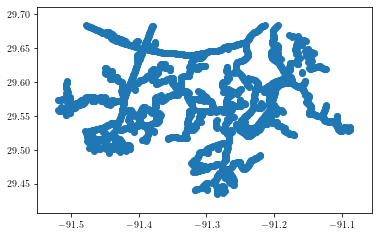

In [9]:
nodes_df = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson').to_crs({'init':'epsg:4326'})
nodes_df.plot()

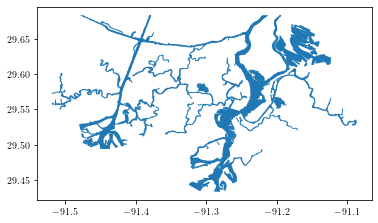

In [10]:
widths_df = gpd.read_file(products_for_map_dir/'width_geometries.geojson').to_crs({'init':'epsg:4326'})
widths_df = widths_df[~widths_df.geometry.is_empty]
widths_df.plot()

In [11]:
with rasterio.open(products_for_map_dir_4326/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    
with rasterio.open(products_for_map_dir_4326/'water_mask.tif') as ds:
    water_mask = ds.read(1)

# Plot

The extents here are specific to [`cartopy`](https://scitools.org.uk/cartopy/docs/latest/).

In [12]:
extent = get_extent(profile['transform'], profile['width'], profile['height'])
# xmin, xmax, ymax, ymin
extent

[-91.5444, -91.086, 29.683199999999996, 29.374499999999998]

In [13]:
ocean_layer = ocean_mask.astype(dtype=float)
ocean_layer[~ocean_mask.astype(bool)] = np.nan

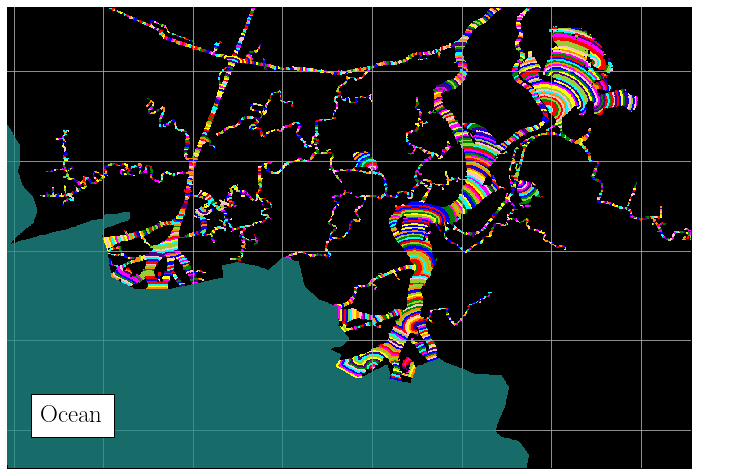

In [14]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 8),
                   labels=False
                   )
ax.set_extent(extent, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857)

ax.imshow(segments, 
             alpha=1, 
             zorder=2, 
             extent=extent,
             transform=ccrs.PlateCarree())



ax.imshow(ocean_layer, 
          alpha=.75, 
          zorder=3, 
          extent=extent,
          vmin=0, vmax=2,
          transform=ccrs.PlateCarree())

width = np.abs(extent[0] - extent[1])
height = np.abs(extent[2] - extent[3])
t = plt.text(extent[0] + .05 * width, 
             extent[3] + .1 * height, 
             r"Ocean", 
             c='black',
             size=25,
             zorder=4)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black', pad=10))

# Source: https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy 
fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
cbar_ax = fig.add_axes([.92, 0.2, 0.025, .65])
cbar_ax.axis('off')

plt.savefig(plots_for_maps_dir/'segments.png')

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


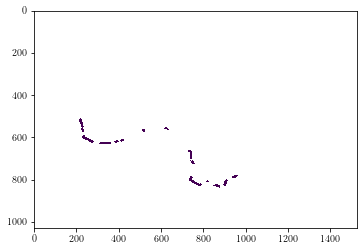

In [15]:
interface = (distance.copy() < 200)
interface = nd.binary_dilation(interface.astype(int), iterations=3).astype(float)
interface[~(interface >0)] = np.nan
plt.imshow(interface)

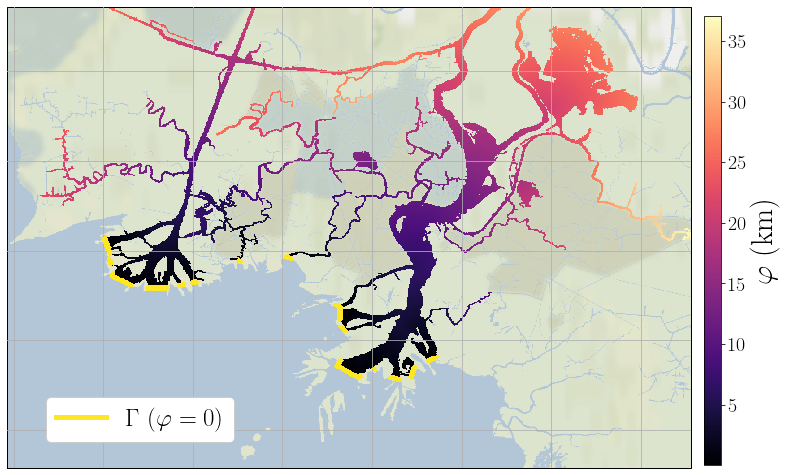

In [16]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 8),
                   labels=False
                   )
ax.set_extent(extent, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857)


im = ax.imshow(distance/1_000, 
             alpha=1, 
             zorder=2, 
             extent=extent,
             transform=ccrs.PlateCarree(), cmap='magma')

ax.imshow(arr, 
             alpha=.75, 
             zorder=1, 
             extent=extent,
             transform=ccrs.PlateCarree())
# ax.imshow(ocean_layer, 
#           alpha=1, 
#           zorder=2, 
#           extent=extent,
#           vmin=1, vmax=2,
#           cmap='magma',
#           transform=ccrs.PlateCarree())


ax.imshow(interface , 
          alpha=1, 
          zorder=3, 
          extent=extent,
          vmin=0, vmax=1,
          cmap='viridis',
          transform=ccrs.PlateCarree())

# width = np.abs(extent[0] - extent[1])
# height = np.abs(extent[2] - extent[3])
# t = plt.text(extent[0] + .05 * width, 
#              extent[3] + .1 * height, 
#              r"$\varphi$ = 0", 
#              c='black',
#              size=25,
#              zorder=5)
# t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black', pad=10))


fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
cbar_ax = fig.add_axes([.91, 0.13, 0.02, .78])
plt.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar_ax.set_ylabel(r'$\varphi$ (km)', fontsize=30)
cbar_ax.tick_params(axis='both', which='major', labelsize=20)

cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=1)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')
legend_elements = [Line2D([0], 
                          [0], 
                          #marker='>',
                          color=scalarMap.to_rgba(1),
                          label=r'$\Gamma$ ($\varphi=0$)',
                          linewidth=5,
                          markersize=10,
                          )]
ax.legend(handles=legend_elements,
          #loc='lower left',
          bbox_to_anchor=(.35, .18), 
          fontsize=25,  
          framealpha=1)


plt.savefig(plots_for_maps_dir/'distance.png')

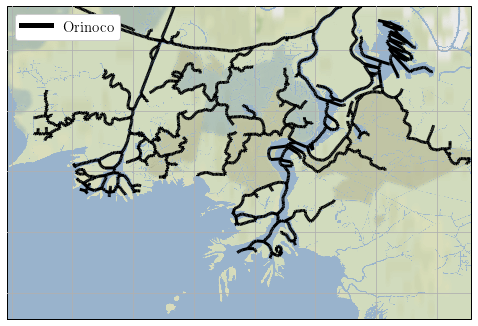

In [17]:
legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='black',
                          label='Orinoco',
                          linewidth=5,
                          markersize=10)]

fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(8.5, 5.75),
                   labels=False
                   )
ax.set_extent(extent, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857))


ax.add_geometries(edges_df.geometry.values, 
                  edgecolor='black',
                  linewidth=3,
                  zorder = 3,
                  crs=ccrs.PlateCarree(),#ccrs.AzimuthalEquidistant(),#fig, ax = make_map(projection=ccrs.epsg(3857),
                 )

ax.imshow(arr, 
             alpha=1, 
             zorder=1, 
             extent=extent,
             transform=ccrs.PlateCarree())
ax.legend(handles=legend_elements, loc='upper left', fontsize=15, framealpha=1)

In [18]:
M = 3
labels = ['Land', 'Deltaic Channels ($\Omega$)', 'Ocean']
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=(M-1))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          alpha=alpha,
                          markersize=10) for alpha, k in zip([1, 1, .75], range(M))]


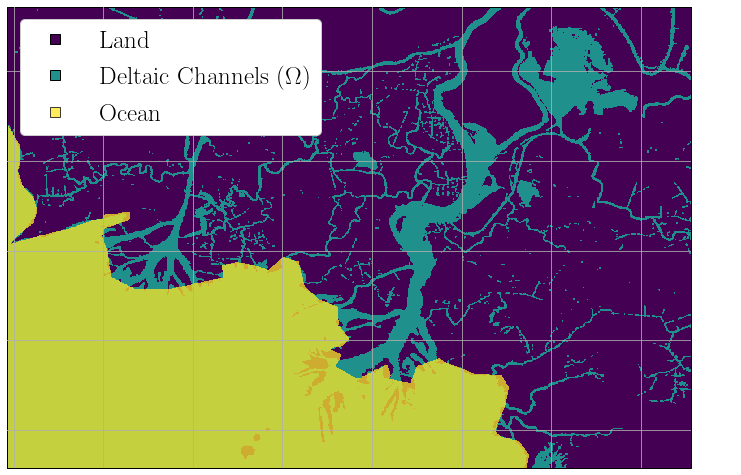

In [19]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 8),
                   labels=False
                   )
ax.set_extent(extent, crs=ccrs.PlateCarree())


ax.imshow(water_mask, alpha=1, 
             zorder=1, 
             extent=extent,
             transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))


ax.imshow(ocean_layer, 
          zorder=1, 
          extent=extent,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmin=0, vmax=1, alpha=.75)
ax.legend(handles=legend_elements, loc='upper left', fontsize=25,  framealpha=1)


fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
cbar_ax = fig.add_axes([.92, 0.2, 0.025, .65])
cbar_ax.axis('off')


plt.savefig(plots_for_maps_dir/'landcover_init.png')

# Cropped for channel Network

In [20]:
# Atchafalaya
if True:
    sy = np.s_[250:1000]
    sx = np.s_[600:1350]
# Wax Lake
else:
    sy = np.s_[250:750]
    sx = np.s_[150:650]

In [21]:
profile_cropped = get_cropped_profile(profile, sx, sy)

extent_c = get_extent(profile_cropped['transform'], profile_cropped['width'], profile_cropped['height'])
edges_c = edges_df.cx[extent_c[0]: extent_c[1], extent_c[3]: extent_c[2]].copy()
nodes_c = nodes_df.cx[extent_c[0]: extent_c[1], extent_c[3]: extent_c[2]].copy()
widths_c = widths_df.cx[extent_c[0]: extent_c[1], extent_c[3]: extent_c[2]].copy()


arr_c = arr[sy, sx]
ocean_layer_c = ocean_layer[sy, sx]
water_mask_c = water_mask[sy, sx]
extent

[-91.5444, -91.086, 29.683199999999996, 29.374499999999998]

In [22]:
H = get_graph_from_edge_dataframe(edges_c)
type(H)

networkx.classes.digraph.DiGraph

In [23]:
chanG = nx.read_gpickle(products_for_map_dir/'channel_network.pkl')
nodes = [(data['x'], data['y']) for data in nodes_c.to_dict('records')]
H = chanG.subgraph(nodes)
type(H), len(H), list(H.nodes())[0]

(networkx.classes.digraph.DiGraph,
 1188,
 (675674.0566037736, 3276504.716981132))

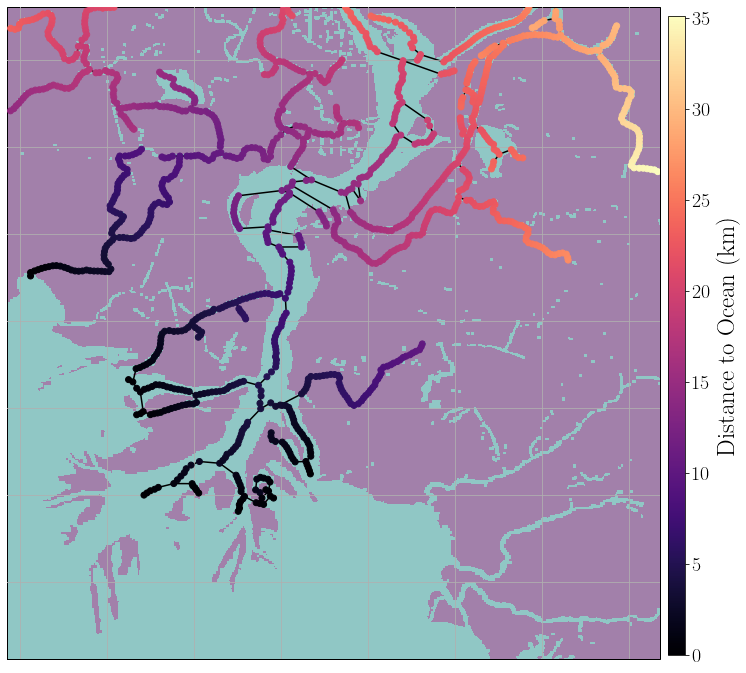

In [24]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 12),
                   labels=False
                   )
plt.rc('font', family='serif', size=20)

ax.set_extent(extent_c, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857))

edges_c.plot(color='black', ax=ax, alpha=1,zorder=2)
nodes_c['km_to_coast'] = (nodes_c.meters_to_interface.values) / 1_000
nodes_c.plot(column='km_to_coast', ax=ax, cmap='magma', zorder=3, linewidth=1)



ax.imshow(water_mask_c, alpha=.5, 
          zorder=1, 
          extent=extent_c,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))



#fig.subplots_adjust(hspace=0, wspace=0, top=1, left=0.0, right=.8)
cax = fig.add_axes([0.9, 0.13, 0.02, 0.74])
vmin = nodes_c.km_to_coast.min()
vmax = nodes_c.km_to_coast.max()
sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

fig.colorbar(sm, cax=cax)
cax.set_ylabel('Distance to Ocean (km)', fontsize=25)
plt.savefig(plots_for_maps_dir/'cropped_node_dist.png')

In [25]:
with rasterio.open(products_for_map_dir/'segments.tif') as ds:
    original_crs = dict(ds.crs)
original_crs

{'init': 'epsg:32615'}

In [26]:
nodes_df['geometry_coords'] =nodes_df['geometry'].map(lambda point: point.coords[0])
nodes_df['geometry_coords_original'] = nodes_df['geometry'].to_crs(original_crs).map(lambda point: point.coords[0])

pos_r = nodes_df.set_index('geometry_coords_original').to_dict()['geometry_coords']
pos_r

{(647577.6011560688, 3267164.306358381): (-91.47715614460836,
  29.525399480245788),
 (647368.3333333326, 3267416.6666666665): (-91.47928087266281,
  29.52770100982686),
 (647500.7874015747, 3266984.842519685): (-91.47797278962801,
  29.52378942320385),
 (649849.606299213, 3267797.834645669): (-91.4536315591818,
  29.530844526517566),
 (649723.347107438, 3267825.2066115704): (-91.45493033891333,
  29.531106625815745),
 (649590.6542056069, 3267844.859813083): (-91.45629655646638,
  29.53129984528903),
 (649467.8191489347, 3267817.287234042): (-91.45756754839124,
  29.53106580103107),
 (649351.0416666662, 3267774.9999999995): (-91.45877805598805,
  29.530698264401217),
 (649231.8181818172, 3267733.2386363633): (-91.46001371715661,
  29.53033575321617),
 (649110.9042553192, 3267699.4680851065): (-91.46126571763958,
  29.530045525118798),
 (648935.8333333333, 3267719.1666666656): (-91.46306911556775,
  29.53024414572208),
 (648865.3645833337, 3267637.4999999995): (-91.46380723084572,
  29.

To plot the graph, we need it in 'epsg:4326'. Unfortunately, using pyproj directly is slow, so we we circuitously use the geopandas API as below.

In [27]:
# Slower, but equivalent

# from pyproj import Proj, transform
# inProj = Proj(init=original_crs)
# outProj = Proj(init='epsg:4326')
# pos_r = {node: transform(inProj,outProj,*node) for node in H.nodes()}

geom = list(map(lambda p: Point(*p), H.nodes()))
nodes_df_temp = gpd.GeoDataFrame(geometry=geom, crs=original_crs)
nodes_df_temp['geometry_r'] = nodes_df_temp.geometry.to_crs({'init':'epsg:4326'})
nodes_df_temp['geometry_r_coords'] = nodes_df_temp['geometry_r'].map(lambda p: p.coords[0])
nodes_df_temp['geometry_coords'] = nodes_df_temp['geometry'].map(lambda p: p.coords[0])
nodes_df_temp.head()

,geometry,geometry_r,geometry_r_coords,geometry_coords
0,POINT (675674.0566037736 3276504.716981132),POINT (-91.18583604019253 29.60601947451663),"(-91.18583604019253, 29.60601947451663)","(675674.0566037736, 3276504.716981132)"
1,POINT (669639.483394834 3269571.586715867),POINT (-91.24920943176861 29.54431318773712),"(-91.2492094317686, 29.54431318773712)","(669639.483394834, 3269571.5867158673)"
2,POINT (663980.6818181818 3270868.181818182),POINT (-91.30739546575543 29.55676672197479),"(-91.30739546575543, 29.556766721974785)","(663980.6818181818, 3270868.1818181816)"
3,POINT (677441 3275221),POINT (-91.16780613755722 29.59418900998627),"(-91.16780613755722, 29.59418900998627)","(677441.0, 3275221.0)"
4,POINT (661812.0967741936 3266806.451612903),POINT (-91.33037386934717 29.5204075440664),"(-91.33037386934717, 29.520407544066398)","(661812.0967741936, 3266806.4516129033)"


In [28]:
pos_r = nodes_df_temp.set_index('geometry_coords').to_dict()['geometry_r_coords']

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


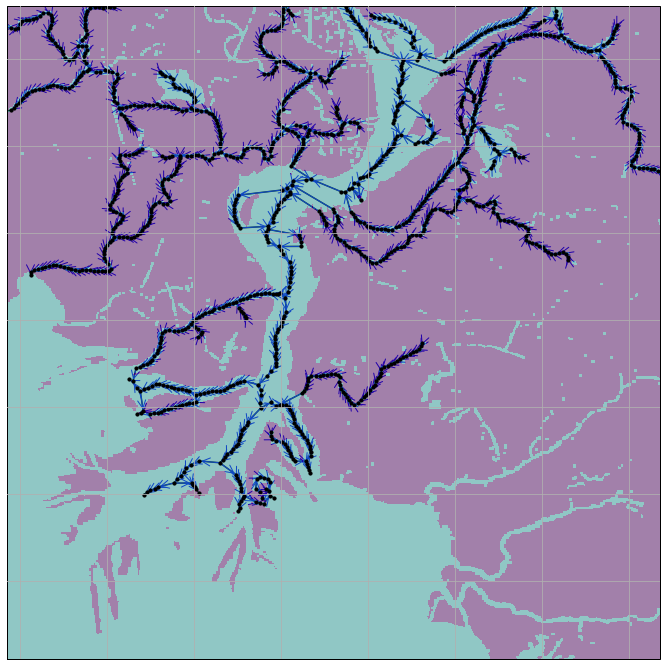

In [29]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 12),
                   labels=False
                   )
ax.set_extent(extent_c, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857))

edges_c.plot(color='black', ax=ax, zorder=1)

ax.imshow(water_mask_c, alpha=.5, 
          zorder=1, 
          extent=extent_c,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))




pos = {node: node for node in H.nodes()}
nx.draw(H, 
        pos=pos_r, 
        node_size=10,
        arrows=True,
        arrowsize=20,
        ax=ax,
        node_color='black',
        arrowstyle='->',
        edge_color='blue',
        edgecolor=(0, 0, 0, 0))

ax.axis('on')
cax = fig.add_axes([0.85, 0.13, 0.04, 0.74])
cax.axis('off')
plt.savefig(plots_for_maps_dir/'cropped_net_dir_arrows_abound.png')

In [30]:
legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='blue',
                          label='Width',
                          linewidth=1,
                          markersize=10)]

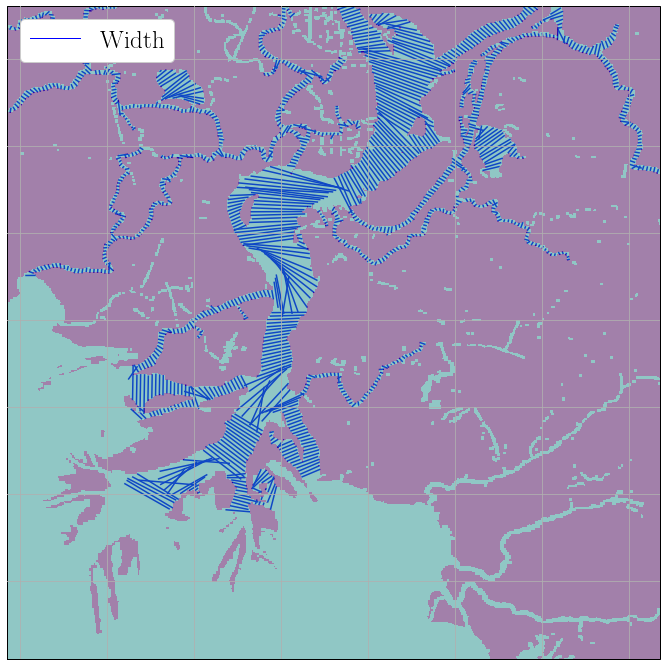

In [31]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 12),
                   labels=False
                   )
ax.set_extent(extent_c, crs=ccrs.PlateCarree())

widths_c.plot(color='blue', ax=ax, zorder=1)

ax.imshow(water_mask_c, alpha=.5, 
          zorder=1, 
          extent=extent_c,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))




pos = {node: node for node in H.nodes()}
nx.draw(H, 
        pos=pos, 
        node_size=1,
        arrows=False,
        arrowsize=12,
        ax=ax,
        node_color='green',
        edgecolor=(0, 0, 0, 0))

ax.axis('on')
cax = fig.add_axes([0.85, 0.13, 0.04, 0.74])
cax.axis('off')

ax.legend(handles=legend_elements, loc='upper left', fontsize=25, framealpha=1)


plt.savefig(plots_for_maps_dir/'cropped_widths.png')

In [32]:
N = edges_c.segment_id.max()
cmap = rand_cmap(N, verbose=False, type='bright')

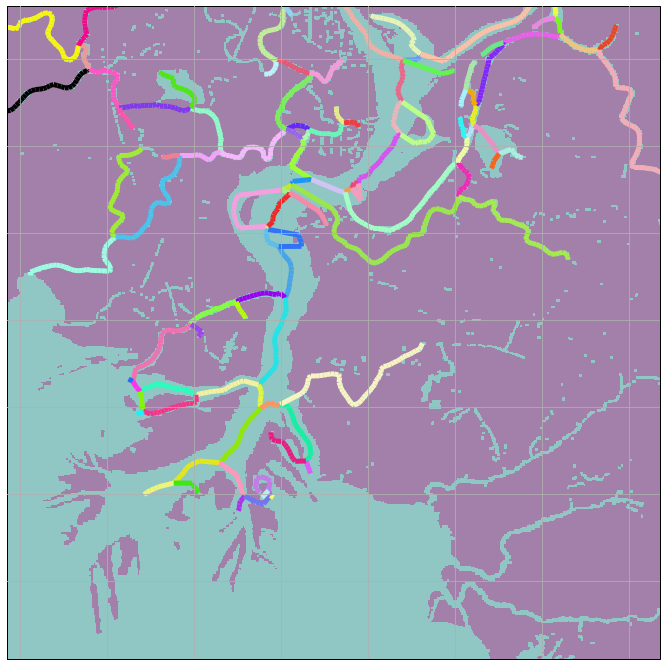

In [33]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 12),
                   labels=False
                   )
ax.set_extent(extent_c, crs=ccrs.PlateCarree())

edges_c.plot(column='segment_id',cmap=cmap, ax=ax, zorder=2, categorical=True, linewidth=5)


ax.imshow(water_mask_c, alpha=.5, 
          zorder=1, 
          extent=extent_c,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))

cax = fig.add_axes([0.85, 0.13, 0.04, 0.74])
cax.axis('off')
plt.savefig(plots_for_maps_dir/'cropped_junction_segments.png')

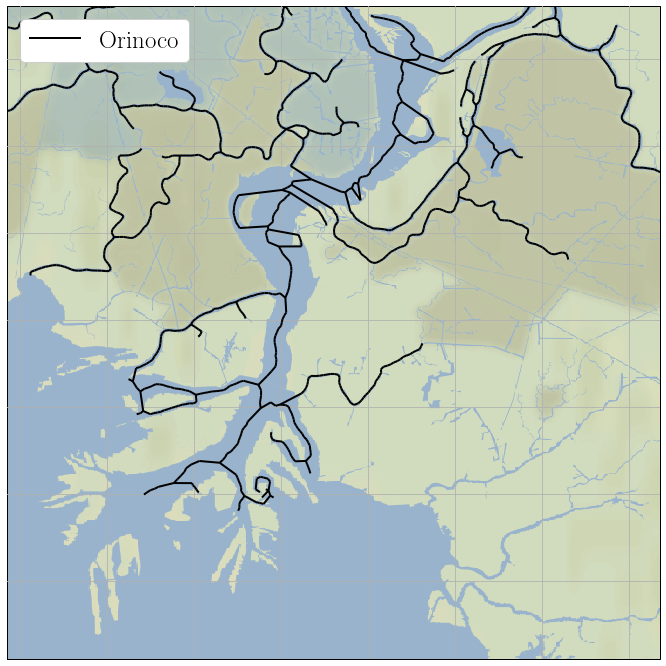

In [34]:
legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='black',
                          label='Orinoco',
                          linewidth=2,
                          markersize=10)]

fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 12),
                   labels=False
                   )
ax.set_extent(extent_c, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857))


ax.add_geometries(edges_c.geometry.values, 
                  edgecolor='black',
                  linewidth=2,
                  zorder = 3,
                  crs=ccrs.PlateCarree(),
                 )

ax.imshow(arr_c, 
             alpha=1, 
             zorder=1, 
             extent=extent_c,
             transform=ccrs.PlateCarree())
ax.legend(handles=legend_elements, loc='upper left', fontsize=25, framealpha=1)
plt.savefig(plots_for_maps_dir/'cropped_centerlines.png')

# Redoing the stream flow figure

In [35]:
from orinoco import dfs_line_search

interface_nodes = [node for node, data in H.node(data=True) if data['interface_adj']]
node_data = dict(H.nodes(data=True))

def dfs_line_search_with_interface(G, source):
    def interface_criterion(node):
        return node_data[node]['interface_adj']
    return dfs_line_search(G, source, break_func=interface_criterion)

random_source = interface_nodes[0]

lines = list(dfs_line_search_with_interface(H.to_undirected(), random_source))

edges_with_arrows_0 = [line[len(line)//3] for line in lines 
                     if len(line) > 2]
edges_with_arrows_1 = [line[len(line)//3] for line in lines 
                     if (node_data[line[-1][0]]['interface_adj']) | (node_data[line[-1][1]]['interface_adj'])]
edges_with_arrows = edges_with_arrows_0 + edges_with_arrows_1
len(edges_with_arrows)

95

In [36]:
legend_elements = [Line2D([0], 
                          [0], 
                          marker='o',
                          color='w',
                          label=f'Outlet',
                          markerfacecolor='green',
                          markeredgecolor='black',
                          alpha=1,
                          markersize=10)]

legend_elements += [Line2D([0], 
                           [0], 
                           marker='>',
                           color='black',
                           markerfacecolor='blue',
                           markeredgecolor='blue',
                           label='Stream flow',
                           linewidth=1,
                           markersize=15)]


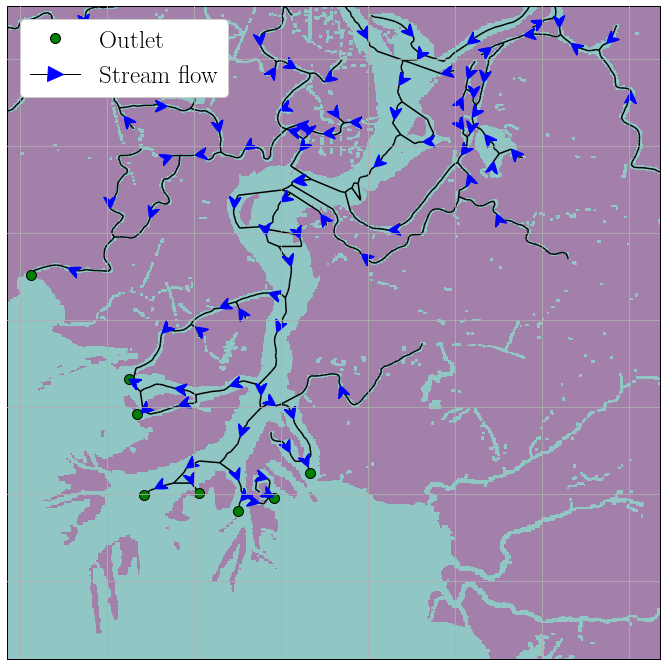

In [37]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 12),
                   labels=False
                   )
ax.set_extent(extent_c, crs=ccrs.PlateCarree())

edges_c.plot(color='black', ax=ax, zorder=1)
nodes_c[nodes_c.interface_adj].plot(color='green', ax=ax, zorder=1, markersize=100, edgecolor='black')


ax.imshow(water_mask_c, alpha=.5, 
          zorder=0, 
          extent=extent_c,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))


ins, outs = zip(*edges_with_arrows)
H2 = H.subgraph(list(set(ins + outs)))
nx.draw_networkx_edges(H2, 
                        pos=pos_r,
                        width=1.2,
                        edge_list=edges_with_arrows,
                        node_size=1,
                        arrows=True,
                        arrowstyle="fancy",
                        arrowsize=28,
                        ax=ax,
                        edge_color='blue',
                        zorder=1,
                        alpha=1,
                       )



ax.axis('on')
cax = fig.add_axes([0.85, 0.13, 0.04, 0.74])
cax.axis('off')

ax.legend(handles=legend_elements, loc='upper left', fontsize=25,  framealpha=1)

plt.savefig(plots_for_maps_dir
            /'cropped_net_dir.png')
